<a href="https://colab.research.google.com/github/rchabo/projet_DDEFi_2025/blob/main/Data_visualisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Appel des bibliothèques

### Installation des bibliothèques

In [ ]:
!pip install eurostat gdown

### Importation des bibliothèques

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
import eurostat
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans
from sklearn import metrics
import seaborn as sns
import plotly.express as px
import gdown

In [ ]:
pd.set_option("display.max_columns", None)

## Utilisation des données via API

### Liste des pays de l'UE :

In [ ]:
#Liste des correspondances entre les codes pays
url = "https://data.enseignementsup-recherche.gouv.fr/api/explore/v2.1/catalog/datasets/curiexplore-pays/records?select=name_en%2Cname_fr%2Ciso2%2Ciso3&where=ue27%20%3D%20%22True%22&limit=-1"
response = requests.get(url)
data = response.json()

# Transformer en DataFrame
code_EU = pd.DataFrame(data['results'])
code_EU

,name_en,name_fr,iso2,iso3
0,Croatia,Croatie,HR,HRV
1,Romania,Roumanie,RO,ROU
2,Latvia,Lettonie,LV,LVA
3,Austria,Autriche,AT,AUT
4,Lithuania,Lituanie,LT,LTU
5,Spain,Espagne,ES,ESP
6,Slovenia,Slovénie,SI,SVN
7,Belgium,Belgique,BE,BEL
8,Netherlands,Pays-Bas,NL,NLD
9,Poland,Pologne,PL,POL


### Données utilisées :

#### Electricity prices for household consumers - bi-annual data

In [ ]:
electricity_price = eurostat.get_data_df('nrg_pc_204')

# Renommer la colonne pour éviter les problèmes avec le backslash
electricity_price = electricity_price.rename(columns={"geo\TIME_PERIOD": "country"})

# Filtrer les lignes où "geo_TIME_PERIOD" est dans la colonne "iso2" de code_EU
electricity_price = electricity_price[electricity_price["country"].isin(code_EU["iso2"])]

#Garder uniquement les unités de mesure d'intérêt
electricity_price = electricity_price[electricity_price["nrg_cons"]=='TOT_KWH'] # TOT_KWH - consommation totale en kWh
electricity_price = electricity_price[electricity_price["tax"]=='X_TAX'] # [X_TAX] - Toutes taxes comprises (All taxes included)
electricity_price = electricity_price[electricity_price["currency"]=='PPS'] # PPS (Purchasing Power Standard) – Standard de pouvoir d'achat

#supprimer les colonnes inutiles
electricity_price = electricity_price.drop(columns=electricity_price.loc[:, "2007-S1":"2021-S1"].columns)
electricity_price = electricity_price.drop(columns=electricity_price.columns[0:electricity_price.columns.get_loc('country')])

# Faire la moyenne des colonnes pour une valeur annuelle
column_index = electricity_price.columns.get_loc('country') #récupérer l'indice de la colonne country
df = electricity_price.iloc[:, (column_index+1):] #Retourne la table avec uniquement les prix
electricity_price['mean_energy_price'] = df.mean(axis=1) #calcul la moyenne des colonnes
electricity_price = electricity_price.iloc[:, [0, -1]] #supprime les valeurs semestrielles déjà moyennées
electricity_price.head()

,country,mean_energy_price
2043,AT,0.198467
2045,BE,0.257600
2046,BG,0.164633
2047,CY,0.226533
2048,CZ,0.263067


In [ ]:
#regarder le pays manquants dans electricity_price

unique_col1 = set(electricity_price["country"]) - set(code_EU["iso2"])  # Présent dans col1 mais pas col2
unique_col2 = set(code_EU["iso2"]) - set(electricity_price["country"])  # Présent dans col2 mais pas col1

print("Uniquement dans electricity_price :", unique_col1)
print("Uniquement dans code_EU :", unique_col2) #il manque GR/Grèce

Uniquement dans electricity_price : set()
Uniquement dans code_EU : {'GR'}


#### Share of energy from renewable sources

In [ ]:
share_renew_energy = eurostat.get_data_df('nrg_ind_ren')

# Renommer la colonne pour éviter les problèmes avec le backslash
share_renew_energy = share_renew_energy.rename(columns={"geo\TIME_PERIOD": "country"})

# Renommer la colonne pour éviter les problèmes de colusions lors du merge
share_renew_energy = share_renew_energy.rename(columns={"2023": "MixEn_2023"})

# Filtrer les lignes où "geo_TIME_PERIOD" est dans la colonne "iso2" de code_EU
share_renew_energy = share_renew_energy[share_renew_energy["country"].isin(code_EU["iso2"])]

#Garder uniquement les unités de mesure d'intérêt
share_renew_energy = share_renew_energy[share_renew_energy["nrg_bal"]=='REN']

#supprimer les colonnes inutiles
share_renew_energy = share_renew_energy.drop(columns=share_renew_energy.columns[0:share_renew_energy.columns.get_loc('country')])

# Faire la moyenne des colonnes pour une valeur annuelle
column_index = share_renew_energy.columns.get_loc('country') #récupérer l'indice de la colonne country
df = share_renew_energy.iloc[:, (column_index+1):] #Retourne la table avec uniquement les prix
share_renew_energy['mean_share_renew_energy'] = df.mean(axis=1) #calcul la moyenne des colonnes
share_renew_energy = share_renew_energy.iloc[:, [0, -1]] #supprime les valeurs semestrielles déjà moyennées
share_renew_energy.head()


,country,mean_share_renew_energy
1,AT,31.83285
3,BE,7.67355
4,BG,16.11650
5,CY,9.75290
6,CZ,12.94330


In [ ]:
#regarder le pays manquants

unique_col1 = set(share_renew_energy["country"]) - set(code_EU["iso2"])  # Présent dans col1 mais pas col2
unique_col2 = set(code_EU["iso2"]) - set(share_renew_energy["country"])  # Présent dans col2 mais pas col1

print("Uniquement dans share_renew_energy :", unique_col1)
print("Uniquement dans code_EU :", unique_col2) #il manque GR/Grèce

Uniquement dans share_renew_energy : set()
Uniquement dans code_EU : {'GR'}


#### Real GDP per capita

In [ ]:
GDP_per_capita = eurostat.get_data_df('sdg_08_10')

# Renommer la colonne pour éviter les problèmes avec le backslash
GDP_per_capita = GDP_per_capita.rename(columns={"geo\TIME_PERIOD": "country"})

# Renommer la colonne pour éviter les problèmes de colusions lors du merge
GDP_per_capita = GDP_per_capita.rename(columns={"2023": "GPDpH_2023"})

# Filtrer les lignes où "geo_TIME_PERIOD" est dans la colonne "iso2" de code_EU
GDP_per_capita = GDP_per_capita[GDP_per_capita["country"].isin(code_EU["iso2"])]

#Garder uniquement les unités de mesure d'intérêt
GDP_per_capita = GDP_per_capita[GDP_per_capita["unit"]=='CLV_PCH_PRE_HAB'] #en parité de pouvoir d'achat par habitatants

#supprimer les colonnes inutiles
GDP_per_capita = GDP_per_capita.drop(columns=GDP_per_capita.columns[0:GDP_per_capita.columns.get_loc('country')])

# Faire la moyenne des colonnes pour une valeur annuelle
column_index = GDP_per_capita.columns.get_loc('country') #récupérer l'indice de la colonne country
df = GDP_per_capita.iloc[:, (column_index+1):] #Retourne la table avec uniquement les prix
GDP_per_capita['mean_GDP_per_capita'] = df.mean(axis=1) #calcul la moyenne des colonnes
GDP_per_capita = GDP_per_capita.iloc[:, [0, -1]] #supprime les valeurs semestrielles déjà moyennées
GDP_per_capita



,country,mean_GDP_per_capita
38,AT,0.916667
39,BE,1.095833
40,BG,4.383333
42,CY,1.825000
43,CZ,2.229167
44,DE,0.960000
45,DK,1.152000
48,EE,3.483333
50,ES,1.012000
52,FI,1.012500


In [ ]:
GDP_per_capita

,country,mean_GDP_per_capita
38,AT,0.916667
39,BE,1.095833
40,BG,4.383333
42,CY,1.825000
43,CZ,2.229167
44,DE,0.960000
45,DK,1.152000
48,EE,3.483333
50,ES,1.012000
52,FI,1.012500


In [ ]:
#regarder le pays manquants

unique_col1 = set(GDP_per_capita["country"]) - set(code_EU["iso2"])  # Présent dans col1 mais pas col2
unique_col2 = set(code_EU["iso2"]) - set(GDP_per_capita["country"])  # Présent dans col2 mais pas col1

print("Uniquement dans GDP_per_capita :", unique_col1)
print("Uniquement dans code_EU :", unique_col2) #il manque GR/Grèce

Uniquement dans GDP_per_capita : set()
Uniquement dans code_EU : {'GR'}


#### HICP - inflation rate

In [ ]:
HICP_inflation = eurostat.get_data_df('tec00118')

# Renommer la colonne pour éviter les problèmes avec le backslash
HICP_inflation = HICP_inflation.rename(columns={"geo\TIME_PERIOD": "country"})

# Renommer la colonne pour éviter les problèmes de colusions lors du merge
HICP_inflation = HICP_inflation.rename(columns={"2024": "HICP_2024"})

# Filtrer les lignes où "geo_TIME_PERIOD" est dans la colonne "iso2" de code_EU
HICP_inflation = HICP_inflation[HICP_inflation["country"].isin(code_EU["iso2"])]

#supprimer les colonnes inutiles
HICP_inflation = HICP_inflation.drop(columns=HICP_inflation.columns[0:HICP_inflation.columns.get_loc('country')])

# Faire la moyenne des colonnes pour une valeur annuelle
column_index = HICP_inflation.columns.get_loc('country') #récupérer l'indice de la colonne country
df = HICP_inflation.iloc[:, (column_index+1):] #Retourne la table avec uniquement les prix
HICP_inflation['mean_HICP_inflation'] = df.mean(axis=1) #calcul la moyenne des colonnes
HICP_inflation = HICP_inflation.iloc[:, [0, -1]] #supprime les valeurs semestrielles déjà moyennées
HICP_inflation.head()

,country,mean_HICP_inflation
1,AT,2.883333
2,BE,2.525000
3,BG,2.575000
5,CY,1.241667
6,CZ,3.816667


In [ ]:
#regarder le pays manquants

unique_col1 = set(HICP_inflation["country"]) - set(code_EU["iso2"])  # Présent dans col1 mais pas col2
unique_col2 = set(code_EU["iso2"]) - set(HICP_inflation["country"])  # Présent dans col2 mais pas col1

print("Uniquement dans HICP_inflation :", unique_col1)
print("Uniquement dans code_EU :", unique_col2) #il manque GR/Grèce

Uniquement dans HICP_inflation : set()
Uniquement dans code_EU : {'GR'}


#### General government deficit/surplus

In [ ]:
GOV_deficit = eurostat.get_data_df('tec00127')

# Renommer la colonne pour éviter les problèmes avec le backslash
GOV_deficit = GOV_deficit.rename(columns={"geo\TIME_PERIOD": "country"})

# Renommer la colonne pour éviter les problèmes de colusions lors du merge
GOV_deficit = GOV_deficit.rename(columns={"2023": "DEFICIT_2023"})

# Filtrer les lignes où "geo_TIME_PERIOD" est dans la colonne "iso2" de code_EU
GOV_deficit = GOV_deficit[GOV_deficit["country"].isin(code_EU["iso2"])]

#Garder uniquement les unités de mesure d'intérêt
GOV_deficit = GOV_deficit[GOV_deficit["unit"]=='PC_GDP']

#supprimer les colonnes inutiles
GOV_deficit = GOV_deficit.drop(columns=GOV_deficit.columns[0:GOV_deficit.columns.get_loc('country')])

# Faire la moyenne des colonnes pour une valeur annuelle
column_index = GOV_deficit.columns.get_loc('country') #récupérer l'indice de la colonne country
df = GOV_deficit.iloc[:, (column_index+1):] #Retourne la table avec uniquement les prix
GOV_deficit['mean_GOV_deficit'] = df.mean(axis=1) #calcul la moyenne des colonnes
GOV_deficit = GOV_deficit.iloc[:, [0, -1]] #supprime les valeurs semestrielles déjà moyennées
GOV_deficit.head()

,country,mean_GOV_deficit
30,AT,-2.333333
31,BE,-3.466667
32,BG,-1.300000
33,CY,-2.733333
34,CZ,-1.841667


#### Energy imports dependency

In [ ]:
NRJ_dependency = eurostat.get_data_df('nrg_ind_id')

# Renommer la colonne pour éviter les problèmes avec le backslash
NRJ_dependency = NRJ_dependency.rename(columns={"geo\TIME_PERIOD": "country"})

# Renommer la colonne pour éviter les problèmes de colusions lors du merge
NRJ_dependency = NRJ_dependency.rename(columns={"2023": "Dep_NRJ_2023"})

# Filtrer les lignes où "geo_TIME_PERIOD" est dans la colonne "iso2" de code_EU
NRJ_dependency = NRJ_dependency[NRJ_dependency["country"].isin(code_EU["iso2"])]

#Garder uniquement les unités de mesure d'intérêt
NRJ_dependency = NRJ_dependency[NRJ_dependency["siec"]=='TOTAL']

#supprimer les colonnes inutiles
NRJ_dependency = NRJ_dependency.drop(columns=NRJ_dependency.columns[0:NRJ_dependency.columns.get_loc('country')])

# Faire la moyenne des colonnes pour une valeur annuelle
column_index = NRJ_dependency.columns.get_loc('country') #récupérer l'indice de la colonne country
df = NRJ_dependency.iloc[:, (column_index+1):] #Retourne la table avec uniquement les prix
NRJ_dependency['mean_NRJ_dependency'] = df.mean(axis=1) #calcul la moyenne des colonnes
NRJ_dependency = NRJ_dependency.iloc[:, [0, -1]] #supprime les valeurs semestrielles déjà moyennées
NRJ_dependency.head()

,country,mean_NRJ_dependency
505,AT,66.289353
507,BE,78.216324
508,BG,46.046500
509,CY,96.887500
510,CZ,27.591353


#### Net greenhouse gas emissions

In [ ]:
CO2_emissions = eurostat.get_data_df('sdg_13_10')

# Renommer la colonne pour éviter les problèmes avec le backslash
CO2_emissions = CO2_emissions.rename(columns={"geo\TIME_PERIOD": "country"})

# Renommer la colonne pour éviter les problèmes de colusions lors du merge
CO2_emissions = CO2_emissions.rename(columns={"2022": "EmCO2_2022"})

# Filtrer les lignes où "geo_TIME_PERIOD" est dans la colonne "iso2" de code_EU
CO2_emissions = CO2_emissions[CO2_emissions["country"].isin(code_EU["iso2"])]

#Garder uniquement les unités de mesure d'intérêt
CO2_emissions = CO2_emissions[CO2_emissions["src_crf"]=='TOTXMEMONIA']
CO2_emissions = CO2_emissions[CO2_emissions["unit"]=='I90']

#supprimer les colonnes inutiles
CO2_emissions = CO2_emissions.drop(columns=CO2_emissions.columns[0:CO2_emissions.columns.get_loc('country')])

# Faire la moyenne des colonnes pour une valeur annuelle
column_index = CO2_emissions.columns.get_loc('country') #récupérer l'indice de la colonne country
df = CO2_emissions.iloc[:, (column_index+1):] #Retourne la table avec uniquement les prix
CO2_emissions['mean_CO2_emissions'] = df.mean(axis=1) #calcul la moyenne des colonnes
CO2_emissions = CO2_emissions.iloc[:, [0, -1]] #supprime les valeurs semestrielles déjà moyennées
CO2_emissions.head()

,country,mean_CO2_emissions
62,AT,105.006061
63,BE,94.218182
64,BG,62.218182
66,CY,144.924242
67,CZ,72.954545


#### Long term government bond yields

In [ ]:
GOV_bound = eurostat.get_data_df('teimf050')

# Renommer la colonne pour éviter les problèmes avec le backslash
GOV_bound = GOV_bound.rename(columns={"geo\TIME_PERIOD": "country"})

# Filtrer les lignes où "geo_TIME_PERIOD" est dans la colonne "iso2" de code_EU
GOV_bound = GOV_bound[GOV_bound["country"].isin(code_EU["iso2"])]

#supprimer les colonnes inutiles
GOV_bound = GOV_bound.drop(columns=GOV_bound.columns[0:GOV_bound.columns.get_loc('country')])

# Faire la moyenne des colonnes pour une valeur annuelle
column_index = GOV_bound.columns.get_loc('country') #récupérer l'indice de la colonne country
df = GOV_bound.iloc[:, (column_index+1):] #Retourne la table avec uniquement les prix
GOV_bound['mean_GOV_bound'] = df.mean(axis=1) #calcul la moyenne des colonnes
GOV_bound = GOV_bound.iloc[:, [0, -1]] #supprime les valeurs semestrielles déjà moyennées
GOV_bound.head()

,country,mean_GOV_bound
0,AT,2.855000
1,BE,2.949167
2,BG,3.930000
3,CY,3.113333
4,CZ,4.005000


#### EU direct investments indicators in % of GDP, impact indicators and rate of return on direct investment (BPM6)

In [ ]:
FDI_impact = eurostat.get_data_df('bop_fdi6_ind')

# Renommer la colonne pour éviter les problèmes avec le backslash
FDI_impact = FDI_impact.rename(columns={"geo\TIME_PERIOD": "country"})

# Filtrer les lignes où "geo_TIME_PERIOD" est dans la colonne "iso2" de code_EU
FDI_impact = FDI_impact[FDI_impact["country"].isin(code_EU["iso2"])]

"""
indic_bp :
[FGDP] GDP (flows in % of GDP)
[SGDP] GDP (stocks in % of GDP)
[IPOS] Rate of return on direct investment (FDI income/FDI stocks)
[PCPOS] FDI stocks (in % of extra EU FDI stocks)
[TIFDI] Market integration - foreign direct investment intensity - average value of inward and outward foreign direct investment flows divided by GDP, multiplied by 100

fdi_item :
[DO__D__F] Direct investment abroad (DIA)
[DI__D__F] Direct investment in the reporting economy (DIRE)
[NAP] Not applicable

"""

#Garder uniquement les unités de mesure d'intérêt
FDI_impact = FDI_impact[FDI_impact['indic_bp']=='IPOS']
FDI_impact = FDI_impact[FDI_impact["fdi_item"]=='DO__D__F']

# Récupérer la dernière valeur
first_col_value = FDI_impact.columns.get_loc('country') + 1 #récupérer l'indeice de la première colonne avce des valeurs
last_col = FDI_impact.shape[1]


FDI_impact = pd.pivot_table(
    FDI_impact,
    values=FDI_impact.columns[first_col_value:last_col],
    index=['country'],
    columns=['indic_bp', 'fdi_item'],
    aggfunc='mean')

FDI_impact.head(100)

,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
indic_bp,IPOS,IPOS,IPOS,IPOS,IPOS,IPOS,IPOS,IPOS,IPOS,IPOS,IPOS
fdi_item,DO__D__F,DO__D__F,DO__D__F,DO__D__F,DO__D__F,DO__D__F,DO__D__F,DO__D__F,DO__D__F,DO__D__F,DO__D__F
country,,,,,,,,,,,
AT,8.592308,5.276923,5.623077,6.623077,5.554545,-4.308333,11.072727,5.390000,7.950000,13.327273,6.230000
BE,5.561538,4.215385,1.980000,50.484615,8.261538,16.507692,9.061538,8.241667,10.750000,5.333333,4.625000
BG,-0.415385,1.146154,2.700000,1.869231,2.238462,-2.107692,7.469231,0.250000,8.250000,3.216667,1.541667
CY,4.650000,4.112500,5.983333,2.300000,2.850000,5.500000,5.380000,4.300000,4.385714,3.550000,4.500000
CZ,-10.923077,-14.508333,-38.411111,-62.472727,-328.740000,-10.315385,8.081818,21.941667,21.333333,17.045455,-11.663636
DE,8.384615,9.330769,8.007692,8.033333,9.930769,8.691667,9.515385,7.338462,7.850000,10.583333,10.858333
DK,10.884615,10.523077,10.969231,7.423077,7.630769,7.192308,11.146154,11.161538,13.733333,9.625000,11.008333


In [ ]:
#Supprimer le multi-index

# Réinitialiser l'index pour récupérer les pays
FDI_impact = FDI_impact.reset_index()

# Vérifier si les colonnes ont un MultiIndex
if isinstance(FDI_impact.columns, pd.MultiIndex):
    # Aplatir les colonnes MultiIndex proprement
    FDI_impact.columns = ['_'.join(filter(None, map(str, col))) for col in FDI_impact.columns]

# Faire la moyenne des colonnes pour une valeur annuelle
column_index = FDI_impact.columns.get_loc('country') #récupérer l'indice de la colonne country
df = FDI_impact.iloc[:, (column_index+1):] #Retourne la table avec uniquement les prix
FDI_impact['mean_FDI_impact'] = df.mean(axis=1) #calcul la moyenne des colonnes
FDI_impact = FDI_impact.iloc[:, [0, -1]] #supprime les valeurs semestrielles déjà moyennées

FDI_impact.head()


,country,mean_FDI_impact
0,AT,6.484691
1,BE,11.365664
2,BG,2.378030
3,CY,4.319232
4,CZ,-37.148363


#### Gross domestic product (GDP) and main components (output, expenditure and income)

In [ ]:
GOV_GDP = eurostat.get_data_df('nama_10_gdp')

# Renommer la colonne pour éviter les problèmes avec le backslash
GOV_GDP = GOV_GDP.rename(columns={"geo\TIME_PERIOD": "country"})

# Renommer la colonne pour éviter les problèmes de colusions lors du merge
GOV_GDP = GOV_GDP.rename(columns={"2023": "PIB_2023"})

# Filtrer les lignes où "geo_TIME_PERIOD" est dans la colonne "iso2" de code_EU
GOV_GDP = GOV_GDP[GOV_GDP["country"].isin(code_EU["iso2"])]

#Garder uniquement les unités de mesure d'intérêt
GOV_GDP = GOV_GDP[GOV_GDP['na_item']=='B1G']
GOV_GDP = GOV_GDP[GOV_GDP["unit"]=='PC_GDP']

#supprimer les colonnes inutiles
GOV_GDP = GOV_GDP.drop(columns=GOV_GDP.columns[0:GOV_GDP.columns.get_loc('country')])

# Faire la moyenne des colonnes pour une valeur annuelle
column_index = GOV_GDP.columns.get_loc('country') #récupérer l'indice de la colonne country
df = GOV_GDP.iloc[:, (column_index+1):] #Retourne la table avec uniquement les prix
GOV_GDP['mean_GOV_GDP'] = df.mean(axis=1) #calcul la moyenne des colonnes
GOV_GDP = GOV_GDP.iloc[:, [0, -1]] #supprime les valeurs semestrielles déjà moyennées
GOV_GDP.head()

,country,mean_GOV_GDP
20380,AT,89.144828
20382,BE,89.534483
20383,BG,87.341379
20385,CY,88.900000
20386,CZ,90.734483


#### Green bond issuance by corporates and governments

In [ ]:
GREEN_Bound = eurostat.get_data_df('sdg_13_70a')

# Renommer la colonne pour éviter les problèmes avec le backslash
GREEN_Bound = GREEN_Bound.rename(columns={"geo\TIME_PERIOD": "country"})

# Filtrer les lignes où "geo_TIME_PERIOD" est dans la colonne "iso2" de code_EU
GREEN_Bound = GREEN_Bound[GREEN_Bound["country"].isin(code_EU["iso2"])]

#supprimer les colonnes inutiles
GREEN_Bound = GREEN_Bound.drop(columns=GREEN_Bound.columns[0:GREEN_Bound.columns.get_loc('country')])

# Faire la moyenne des colonnes pour une valeur annuelle
column_index = GREEN_Bound.columns.get_loc('country') #récupérer l'indice de la colonne country
df = GREEN_Bound.iloc[:, (column_index+1):] #Retourne la table avec uniquement les prix
GREEN_Bound['mean_GREEN_Bound'] = df.mean(axis=1) #calcul la moyenne des colonnes
GREEN_Bound = GREEN_Bound.iloc[:, [0, -1]] #supprime les valeurs semestrielles déjà moyennées
GREEN_Bound.head()


,country,mean_GREEN_Bound
0,AT,8.3
1,BE,14.8
2,BG,0.0
3,CY,0.0
4,CZ,3.3


#### Climate related economic losses – values at constant 2022 prices

In [ ]:
GREEN_Losses = eurostat.get_data_df('sdg_13_40')

# Renommer la colonne pour éviter les problèmes avec le backslash
GREEN_Losses = GREEN_Losses.rename(columns={"geo\TIME_PERIOD": "country"})

# Filtrer les lignes où "geo_TIME_PERIOD" est dans la colonne "iso2" de code_EU
GREEN_Losses = GREEN_Losses[GREEN_Losses["country"].isin(code_EU["iso2"])]
"""
[VAL_A] Annual value
[AVG_30Y] Thirty-year average
[CP_MEUR] Current prices, million euro
[CP_EUR_HAB] Current prices, euro per capita
"""
#Garder uniquement les unités de mesure d'intérêt
GREEN_Losses = GREEN_Losses[GREEN_Losses['statinfo']=='VAL_A']
GREEN_Losses = GREEN_Losses[GREEN_Losses["unit"]=='CP_EUR_HAB']

#supprimer les colonnes inutiles
GREEN_Losses = GREEN_Losses.drop(columns=GREEN_Losses.columns[0:GREEN_Losses.columns.get_loc('country')])

# Faire la moyenne des colonnes pour une valeur annuelle
column_index = GREEN_Losses.columns.get_loc('country') #récupérer l'indice de la colonne country
df = GREEN_Losses.iloc[:, (column_index+1):] #Retourne la table avec uniquement les prix
GREEN_Losses['mean_GREEN_Losses'] = df.mean(axis=1) #calcul la moyenne des colonnes
GREEN_Losses = GREEN_Losses.iloc[:, [0, -1]] #supprime les valeurs semestrielles déjà moyennées
GREEN_Losses.head()


,country,mean_GREEN_Losses
66,AT,40.223636
67,BE,34.092500
68,BG,16.006136
70,CY,12.567045
71,CZ,40.780682


#### Contribution to the international 100bn USD commitment on climate related expending (source: DG CLIMA, EIONET)

In [ ]:
GREEN_COP21 = eurostat.get_data_df('sdg_13_50')

# Renommer la colonne pour éviter les problèmes avec le backslash
GREEN_COP21 = GREEN_COP21.rename(columns={"geo\TIME_PERIOD": "country"})

# Filtrer les lignes où "geo_TIME_PERIOD" est dans la colonne "iso2" de code_EU
GREEN_COP21 = GREEN_COP21[GREEN_COP21["country"].isin(code_EU["iso2"])]

#supprimer les colonnes inutiles
GREEN_COP21 = GREEN_COP21.drop(columns=GREEN_COP21.columns[0:GREEN_COP21.columns.get_loc('country')])

# Faire la moyenne des colonnes pour une valeur annuelle
column_index = GREEN_COP21.columns.get_loc('country') #récupérer l'indice de la colonne country
df = GREEN_COP21.iloc[:, (column_index+1):] #Retourne la table avec uniquement les prix
GREEN_COP21['mean_GREEN_COP21'] = df.sum(axis=1) #calcul la moyenne des colonnes
GREEN_COP21 = GREEN_COP21.iloc[:, [0, -1]] #supprime les valeurs semestrielles déjà moyennées
GREEN_COP21.head()

,country,mean_GREEN_COP21
0,AT,2641.17
1,BE,1614.33
2,BG,0.47
4,CY,0.00
5,CZ,86.71


#### Gross value added in environmental goods and services sector

In [ ]:
GREEN_gross_value = eurostat.get_data_df('sdg_12_61')

# Renommer la colonne pour éviter les problèmes avec le backslash
GREEN_gross_value = GREEN_gross_value.rename(columns={"geo\TIME_PERIOD": "country"})

# Filtrer les lignes où "geo_TIME_PERIOD" est dans la colonne "iso2" de code_EU
GREEN_gross_value = GREEN_gross_value[GREEN_gross_value["country"].isin(code_EU["iso2"])]

"""
[CLV10_MEUR] Chain linked volumes (2010), million euro
[PC_GDP] Percentage of gross domestic product (GDP)
"""
#Garder uniquement les unités de mesure d'intérêt
GREEN_gross_value = GREEN_gross_value[GREEN_gross_value['unit']=='PC_GDP']

#supprimer les colonnes inutiles
GREEN_gross_value = GREEN_gross_value.drop(columns=GREEN_gross_value.columns[0:GREEN_gross_value.columns.get_loc('country')])

# Faire la moyenne des colonnes pour une valeur annuelle
column_index = GREEN_gross_value.columns.get_loc('country') #récupérer l'indice de la colonne country
df = GREEN_gross_value.iloc[:, (column_index+1):] #Retourne la table avec uniquement les prix
GREEN_gross_value['mean_GREEN_gross_value'] = df.mean(axis=1) #calcul la moyenne des colonnes
GREEN_gross_value = GREEN_gross_value.iloc[:, [0, -1]] #supprime les valeurs semestrielles déjà moyennées

GREEN_gross_value.head()

,country,mean_GREEN_gross_value
34,AT,4.484000
35,BE,1.795556
36,BG,2.332000
38,CY,1.832000
39,CZ,2.486667


#### Energy productivity

In [ ]:
NRJ_productivity = eurostat.get_data_df('sdg_07_30')

# Renommer la colonne pour éviter les problèmes avec le backslash
NRJ_productivity = NRJ_productivity.rename(columns={"geo\TIME_PERIOD": "country"})

# Filtrer les lignes où "geo_TIME_PERIOD" est dans la colonne "iso2" de code_EU
NRJ_productivity = NRJ_productivity[NRJ_productivity["country"].isin(code_EU["iso2"])]

"""
[EUR_KGOE] Euro per kilogram of oil equivalent (KGOE)
[PPS_KGOE] Purchasing power standard (PPS) per kilogram of oil equivalent
"""
#Garder uniquement les unités de mesure d'intérêt
NRJ_productivity = NRJ_productivity[NRJ_productivity['unit']=='PPS_KGOE']

#supprimer les colonnes inutiles
NRJ_productivity = NRJ_productivity.drop(columns=NRJ_productivity.columns[0:NRJ_productivity.columns.get_loc('country')])

# Faire la moyenne des colonnes pour une valeur annuelle
column_index = NRJ_productivity.columns.get_loc('country') #récupérer l'indice de la colonne country
df = NRJ_productivity.iloc[:, (column_index+1):] #Retourne la table avec uniquement les prix
NRJ_productivity['mean_NRJ_productivity'] = df.mean(axis=1) #calcul la moyenne des colonnes
NRJ_productivity = NRJ_productivity.iloc[:, [0, -1]] #supprime les valeurs semestrielles déjà moyennées

NRJ_productivity.head()

,country,mean_NRJ_productivity
39,AT,8.568333
41,BE,5.556667
42,BG,4.720000
43,CY,7.485000
44,CZ,5.612500


#### Premature deaths due to exposure to fine particulate matter (PM2.5)

In [ ]:
POLL_death = eurostat.get_data_df('sdg_11_52')

# Renommer la colonne pour éviter les problèmes avec le backslash
POLL_death = POLL_death.rename(columns={"geo\TIME_PERIOD": "country"})

# Filtrer les lignes où "geo_TIME_PERIOD" est dans la colonne "iso2" de code_EU
POLL_death = POLL_death[POLL_death["country"].isin(code_EU["iso2"])]

"""
[NR] Number
[RT] Rate
"""
#Garder uniquement les unités de mesure d'intérêt
POLL_death = POLL_death[POLL_death['unit']=='RT']

#supprimer les colonnes inutiles
POLL_death = POLL_death.drop(columns=POLL_death.columns[0:POLL_death.columns.get_loc('country')])

# Faire la moyenne des colonnes pour une valeur annuelle
column_index = POLL_death.columns.get_loc('country') #récupérer l'indice de la colonne country
df = POLL_death.iloc[:, (column_index+1):] #Retourne la table avec uniquement les prix
POLL_death['mean_POLL_death'] = df.mean(axis=1) #calcul la moyenne des colonnes
POLL_death = POLL_death.iloc[:, [0, -1]] #supprime les valeurs semestrielles déjà moyennées

POLL_death.head()

,country,mean_POLL_death
39,AT,58.470588
41,BE,62.411765
42,BG,205.941176
44,CY,88.764706
45,CZ,90.882353


#### Environmental tax revenues

In [ ]:
GREEN_tax = eurostat.get_data_df('env_ac_tax')

# Renommer la colonne pour éviter les problèmes avec le backslash
GREEN_tax = GREEN_tax.rename(columns={"geo\TIME_PERIOD": "country"})

# Filtrer les lignes où "geo_TIME_PERIOD" est dans la colonne "iso2" de code_EU
GREEN_tax = GREEN_tax[GREEN_tax["country"].isin(code_EU["iso2"])]

"""
[ENV] Total environmental taxes
[NRG] Energy taxes
[TRA] Transport taxes
[POL_RES] Taxes on pollution/resources

[MIO_EUR] Million euro
[MIO_NAC] Million units of national currency
[PC_TSCO] Percentage of total revenues from taxes and social contributions (including imputed social contributions)
[PC_TSCO_X_ISCO] Percentage of total revenues from taxes and social contributions (excluding imputed social contributions)
[PC_GDP] Percentage of gross domestic product (GDP)
"""
#Garder uniquement les unités de mesure d'intérêt
GREEN_tax = GREEN_tax[GREEN_tax['tax']=='ENV']
GREEN_tax = GREEN_tax[GREEN_tax['unit']=='PC_GDP']

#supprimer les colonnes inutiles
GREEN_tax = GREEN_tax.drop(columns=GREEN_tax.columns[0:GREEN_tax.columns.get_loc('country')])

# Faire la moyenne des colonnes pour une valeur annuelle
column_index = GREEN_tax.columns.get_loc('country') #récupérer l'indice de la colonne country
df = GREEN_tax.iloc[:, (column_index+1):] #Retourne la table avec uniquement les prix
GREEN_tax['mean_GREEN_tax'] = df.mean(axis=1) #calcul la moyenne des colonnes
GREEN_tax = GREEN_tax.iloc[:, [0, -1]] #supprime les valeurs semestrielles déjà moyennées

GREEN_tax.head()

,country,mean_GREEN_tax
64,AT,2.444828
65,BE,2.485172
66,BG,2.704483
68,CY,3.049310
69,CZ,2.159655


#### Employment in the environmental goods and services sector

In [ ]:
GREEN_employment = eurostat.get_data_df('env_ac_egss1')

# Renommer la colonne pour éviter les problèmes avec le backslash
GREEN_employment = GREEN_employment.rename(columns={"geo\TIME_PERIOD": "country"})

# Filtrer les lignes où "geo_TIME_PERIOD" est dans la colonne "iso2" de code_EU
GREEN_employment = GREEN_employment[GREEN_employment["country"].isin(code_EU["iso2"])]

"""
[TOT_EGSS] Total environmental goods and services sector
[ANC] Ancillary activities
[MKT] Market activities
[ES_CS] Market activities: environmental specific and connected services
[C_REP] Market activities: cleaner and resource efficient products
[NMKT] Non-market activities
[OWN_USE] Own final use activities
"""
#Garder uniquement les unités de mesure d'intérêt
GREEN_employment = GREEN_employment[GREEN_employment['ty']=='TOT_EGSS']

GREEN_employment = GREEN_employment.groupby('country').sum()
GREEN_employment.reset_index(inplace=True)

#supprimer les colonnes inutiles
GREEN_employment = GREEN_employment.drop(columns=GREEN_employment.columns[1:GREEN_employment.columns.get_loc('unit')+1])

# Faire la moyenne des colonnes pour une valeur annuelle
df = GREEN_employment.iloc[:, 1:] #Retourne la table avec uniquement les prix
GREEN_employment['mean_GREEN_employment'] = df.sum(axis=1) #calcul la moyenne des colonnes
GREEN_employment = GREEN_employment.iloc[:, [0, -1]] #supprime les valeurs semestrielles déjà moyennées

GREEN_employment

,country,mean_GREEN_employment
0,AT,19383640.0
1,BE,5045574.0
2,BG,3773866.0
3,CY,372371.0
4,CZ,7642963.0
5,DE,38082271.0
6,DK,6043897.0
7,EE,2096800.0
8,ES,31114862.0
9,FI,10686157.0


#### Investments in climate change mitigation by NACE Rev. 2 activity

In [ ]:
GREEN_investments = eurostat.get_data_df('env_ac_ccminv')

# Renommer la colonne pour éviter les problèmes avec le backslash
GREEN_investments = GREEN_investments.rename(columns={"geo\TIME_PERIOD": "country"})

# Filtrer les lignes où "geo_TIME_PERIOD" est dans la colonne "iso2" de code_EU
GREEN_investments = GREEN_investments[GREEN_investments["country"].isin(code_EU["iso2"])]

"""
[TOTAL] Total - all NACE activities
[A] Agriculture, forestry and fishing
[B] Mining and quarrying
[C] Manufacturing
[D] Electricity, gas, steam and air conditioning supply

[MIO_EUR] Million euro
[PC_GDP] Percentage of gross domestic product (GDP)
[CLV20_MEUR] Chain linked volumes (2020), million euro
"""
#Garder uniquement les unités de mesure d'intérêt
GREEN_investments = GREEN_investments[GREEN_investments['nace_r2']=='TOTAL']
GREEN_investments = GREEN_investments[GREEN_investments['unit']=='CLV20_MEUR']

#supprimer les colonnes inutiles
GREEN_investments = GREEN_investments.drop(columns=GREEN_investments.columns[0:GREEN_investments.columns.get_loc('country')])

# Faire la moyenne des colonnes pour une valeur annuelle
column_index = GREEN_investments.columns.get_loc('country') #récupérer l'indice de la colonne country
df = GREEN_investments.iloc[:, (column_index+1):] #Retourne la table avec uniquement les prix
GREEN_investments['mean_GREEN_investments'] = df.mean(axis=1) #calcul la moyenne des colonnes
GREEN_investments = GREEN_investments.iloc[:, [0, -1]] #supprime les valeurs semestrielles déjà moyennées

GREEN_investments.head()

,country,mean_GREEN_investments
857,AT,3213.635789
858,BE,3966.281053
859,BG,450.814737
860,CY,26.490000
861,CZ,1208.926316


#### Environmental protection investments of total economy

In [ ]:
GREEN_enviro_protection = eurostat.get_data_df('env_ac_epite1')

# Renommer la colonne pour éviter les problèmes avec le backslash
GREEN_enviro_protection = GREEN_enviro_protection.rename(columns={"geo\TIME_PERIOD": "country"})

# Filtrer les lignes où "geo_TIME_PERIOD" est dans la colonne "iso2" de code_EU
GREEN_enviro_protection = GREEN_enviro_protection[GREEN_enviro_protection["country"].isin(code_EU["iso2"])]

#Garder uniquement les unités de mesure d'intérêt
GREEN_enviro_protection = GREEN_enviro_protection[GREEN_enviro_protection['unit']=='PC_GDP']

#supprimer les colonnes inutiles
GREEN_enviro_protection = GREEN_enviro_protection.drop(columns=GREEN_enviro_protection.columns[0:GREEN_enviro_protection.columns.get_loc('country')])

# Faire la moyenne des colonnes pour une valeur annuelle
column_index = GREEN_enviro_protection.columns.get_loc('country') #récupérer l'indice de la colonne country
df = GREEN_enviro_protection.iloc[:, (column_index+1):] #Retourne la table avec uniquement les prix
GREEN_enviro_protection['mean_GREEN_enviro_protection'] = df.mean(axis=1) #calcul la moyenne des colonnes
GREEN_enviro_protection = GREEN_enviro_protection.iloc[:, [0, -1]] #supprime les valeurs semestrielles déjà moyennées

GREEN_enviro_protection.head(100)

,country,mean_GREEN_enviro_protection
28,AT,0.325000
29,BE,0.462500
30,BG,0.862500
32,CY,0.418182
33,CZ,0.750000
34,DE,0.400000
35,DK,0.437500
36,EE,0.650000
38,ES,0.246154
40,FI,0.260000


#### CCPI des pays en 2024

In [ ]:
# ID du fichier Google Drive (L'ID du fichier est la partie entre /d/ et /edit.)
file_id = '1OCd3tciUqE7zKyOWzk6M8h0vxy7vRZ95'

# Nom du fichier à enregistrer localement
output_file = 'CCPI.csv'

# Télécharger le fichier depuis Google Drive
gdown.download(f'https://drive.google.com/uc?id={file_id}', output_file, quiet=False)
CCPI = pd.read_csv(output_file)
CCPI = CCPI[["PAYS","CCPI"]]
CCPI.rename(columns={'PAYS': 'country'}, inplace=True)
CCPI = CCPI.iloc[:31]

CCPI

Downloading...
From: https://drive.google.com/uc?id=1OCd3tciUqE7zKyOWzk6M8h0vxy7vRZ95
To: /content/CCPI.csv
100%|██████████| 3.77k/3.77k [00:00<00:00, 6.00MB/s]


,country,CCPI
0,Denmark,78.37
1,Netherlands,69.60
2,United Kingdom,69.29
3,Norway,68.21
4,Sweden,67.62
5,Luxembourg,67.29
6,Estonia,66.79
7,Portugal,66.59
8,Germany,64.91
9,European Union (27),63.76


In [ ]:
#Ajout colonne iso2 et iso3
CCPI['iso2'] = CCPI['country'].map(code_EU.set_index('name_en')['iso2'])
CCPI['iso3'] = CCPI['country'].map(code_EU.set_index('name_en')['iso3'])

display(CCPI)

,country,CCPI,iso2,iso3
0,Denmark,78.37,NaN,NaN
1,Netherlands,69.60,NL,NLD
2,United Kingdom,69.29,NaN,NaN
3,Norway,68.21,NaN,NaN
4,Sweden,67.62,SE,SWE
5,Luxembourg,67.29,LU,LUX
6,Estonia,66.79,EE,EST
7,Portugal,66.59,PT,PRT
8,Germany,64.91,DE,DEU
9,European Union (27),63.76,NaN,NaN


## Exploration et analyse des données

In [ ]:
# Liste des DataFrames à fusionner
dataframes = [
    electricity_price, GDP_per_capita, HICP_inflation, NRJ_dependency, NRJ_productivity, POLL_death,
    GREEN_Bound, GREEN_COP21, GREEN_Losses, GREEN_employment, GREEN_enviro_protection, GREEN_gross_value,
    GREEN_investments, GREEN_tax, FDI_impact, GOV_GDP, GOV_bound, GOV_deficit, share_renew_energy, CO2_emissions
]

# Fusionner les DataFrames successivement
data = code_EU.rename(columns={'iso2': 'country'})

for df in dataframes:
    data = pd.merge(data, df, on='country', how='left')

data.dropna(inplace=True) #supprimer la Grèce

# Afficher un aperçu des données fusionnées
data

,name_en,name_fr,country,iso3,mean_energy_price,mean_GDP_per_capita,mean_HICP_inflation,mean_NRJ_dependency,mean_NRJ_productivity,mean_POLL_death,mean_GREEN_Bound,mean_GREEN_COP21,mean_GREEN_Losses,mean_GREEN_employment,mean_GREEN_enviro_protection,mean_GREEN_gross_value,mean_GREEN_investments,mean_GREEN_tax,mean_FDI_impact,mean_GOV_GDP,mean_GOV_bound,mean_GOV_deficit,mean_share_renew_energy,mean_CO2_emissions
0,Croatia,Croatie,HR,HRV,0.175217,2.945833,2.591667,47.643618,7.673333,114.941176,0.0,0.47,22.510682,2319895.0,0.562500,1.644444,375.637368,3.682759,-6.537475,83.376667,3.284167,-2.541667,26.50435,79.372727
1,Romania,Roumanie,RO,ROU,0.287683,4.429167,3.841667,26.227059,8.495833,126.117647,0.7,52.97,21.244773,19107921.0,0.558824,2.802000,2227.852105,2.294828,12.117424,90.237931,6.394167,-4.091667,22.44690,49.530303
2,Latvia,Lettonie,LV,LVA,0.289067,4.468000,3.341667,58.673618,6.618750,73.411765,10.5,0.82,13.584318,1640729.0,0.400000,2.837778,458.715789,2.701034,6.196840,88.116667,3.273333,-2.208333,36.54865,43.642424
3,Austria,Autriche,AT,AUT,0.198467,0.916667,2.883333,66.289353,8.568333,58.470588,8.3,2641.17,40.223636,19383640.0,0.325000,4.484000,3213.635789,2.444828,6.484691,89.144828,2.855000,-2.333333,31.83285,105.006061
4,Lithuania,Lituanie,LT,LTU,0.247333,4.780000,3.666667,63.143147,6.910417,76.235294,0.0,18.99,16.253864,3705280.0,0.691667,2.415385,666.511053,2.072414,0.894307,89.506667,2.880000,-1.308333,22.81555,39.812121
5,Spain,Espagne,ES,ESP,0.252800,1.012000,1.850000,73.347853,8.361250,44.058824,7.6,6967.47,52.181136,31114862.0,0.246154,2.469000,4896.697895,1.860690,8.106235,91.203333,3.149167,-5.666667,15.26090,121.993939
6,Slovenia,Slovénie,SI,SVN,0.165267,2.124000,2.225000,49.982029,6.699583,74.411765,0.0,42.87,191.309091,2391372.0,0.914286,1.606923,355.560000,3.664138,7.977310,87.053333,3.112500,-3.408333,21.74110,98.715152
7,Belgium,Belgique,BE,BEL,0.257600,1.095833,2.525000,78.216324,5.556667,62.411765,14.8,1614.33,34.092500,5045574.0,0.462500,1.795556,3966.281053,2.485172,11.365664,89.534483,2.949167,-3.466667,7.67355,94.218182
8,Netherlands,Pays-Bas,NL,NLD,0.250000,1.116000,2.633333,37.543235,6.666667,50.941176,11.1,6742.48,15.590000,19285852.0,0.477778,2.131818,2641.880000,3.531034,5.896115,89.556667,2.640000,-1.008333,6.78340,96.000000
9,Poland,Pologne,PL,POL,0.167360,3.729167,3.466667,21.813794,6.564583,114.058824,3.8,147.37,12.435682,15233320.0,0.600000,2.348889,2674.091579,2.471724,10.176542,88.282759,5.583333,-3.033333,11.36660,84.763636


In [ ]:
dataframe = data.copy()
dataframe.drop(columns=['name_en','name_fr','country','iso3'], inplace=True)

Les corrélations

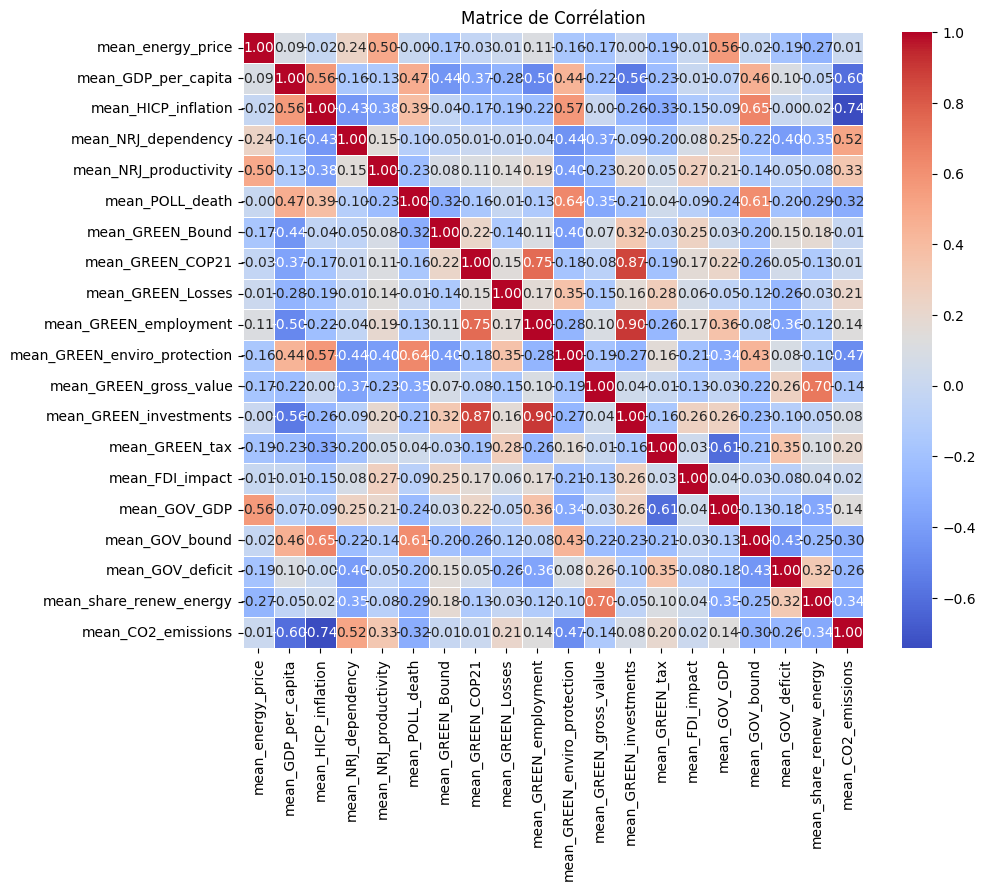

In [ ]:
corr_matrix = dataframe.corr()

# Afficher la matrice sous forme de heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matrice de Corrélation")
plt.show()

## Modèle de Machine Learning

###Random forrest

In [ ]:
#Calcul des seuils
seuil_GOV_GDP = data['mean_GOV_GDP'].mean()
seuil_CO2_emissions = data['mean_CO2_emissions'].mean()
seuil_share_renew_energy = data['mean_share_renew_energy'].mean()

print(seuil_GOV_GDP)
print(seuil_CO2_emissions)
print(seuil_share_renew_energy)


88.56782053999737
85.06472727272727
19.703802


In [ ]:
#Test création de label seuils
data['besoin_aide'] = ((data['mean_GOV_GDP'] < 90) & (data['mean_share_renew_energy'] < 21)).astype(int)
data

,name_en,name_fr,country,iso3,mean_energy_price,mean_GDP_per_capita,mean_HICP_inflation,mean_NRJ_dependency,mean_NRJ_productivity,mean_POLL_death,mean_GREEN_Bound,mean_GREEN_COP21,mean_GREEN_Losses,mean_GREEN_employment,mean_GREEN_enviro_protection,mean_GREEN_gross_value,mean_GREEN_investments,mean_GREEN_tax,mean_FDI_impact,mean_GOV_GDP,mean_GOV_bound,mean_GOV_deficit,mean_share_renew_energy,mean_CO2_emissions,besoin_aide
0,Croatia,Croatie,HR,HRV,0.175217,2.945833,2.591667,47.643618,7.673333,114.941176,0.0,0.47,22.510682,2319895.0,0.562500,1.644444,375.637368,3.682759,-6.537475,83.376667,3.284167,-2.541667,26.50435,79.372727,0
1,Romania,Roumanie,RO,ROU,0.287683,4.429167,3.841667,26.227059,8.495833,126.117647,0.7,52.97,21.244773,19107921.0,0.558824,2.802000,2227.852105,2.294828,12.117424,90.237931,6.394167,-4.091667,22.44690,49.530303,0
2,Latvia,Lettonie,LV,LVA,0.289067,4.468000,3.341667,58.673618,6.618750,73.411765,10.5,0.82,13.584318,1640729.0,0.400000,2.837778,458.715789,2.701034,6.196840,88.116667,3.273333,-2.208333,36.54865,43.642424,0
3,Austria,Autriche,AT,AUT,0.198467,0.916667,2.883333,66.289353,8.568333,58.470588,8.3,2641.17,40.223636,19383640.0,0.325000,4.484000,3213.635789,2.444828,6.484691,89.144828,2.855000,-2.333333,31.83285,105.006061,0
4,Lithuania,Lituanie,LT,LTU,0.247333,4.780000,3.666667,63.143147,6.910417,76.235294,0.0,18.99,16.253864,3705280.0,0.691667,2.415385,666.511053,2.072414,0.894307,89.506667,2.880000,-1.308333,22.81555,39.812121,0
5,Spain,Espagne,ES,ESP,0.252800,1.012000,1.850000,73.347853,8.361250,44.058824,7.6,6967.47,52.181136,31114862.0,0.246154,2.469000,4896.697895,1.860690,8.106235,91.203333,3.149167,-5.666667,15.26090,121.993939,0
6,Slovenia,Slovénie,SI,SVN,0.165267,2.124000,2.225000,49.982029,6.699583,74.411765,0.0,42.87,191.309091,2391372.0,0.914286,1.606923,355.560000,3.664138,7.977310,87.053333,3.112500,-3.408333,21.74110,98.715152,0
7,Belgium,Belgique,BE,BEL,0.257600,1.095833,2.525000,78.216324,5.556667,62.411765,14.8,1614.33,34.092500,5045574.0,0.462500,1.795556,3966.281053,2.485172,11.365664,89.534483,2.949167,-3.466667,7.67355,94.218182,1
8,Netherlands,Pays-Bas,NL,NLD,0.250000,1.116000,2.633333,37.543235,6.666667,50.941176,11.1,6742.48,15.590000,19285852.0,0.477778,2.131818,2641.880000,3.531034,5.896115,89.556667,2.640000,-1.008333,6.78340,96.000000,1
9,Poland,Pologne,PL,POL,0.167360,3.729167,3.466667,21.813794,6.564583,114.058824,3.8,147.37,12.435682,15233320.0,0.600000,2.348889,2674.091579,2.471724,10.176542,88.282759,5.583333,-3.033333,11.36660,84.763636,1


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# 1. Préparer les features et le label
X = data[['mean_share_renew_energy', 'mean_GOV_GDP']]  # Variables explicatives
y = data['besoin_aide']  # Variable cible

# 2. Diviser les données en train (80%) et test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 3. Entraîner le modèle Random Forest
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)

# 4. Prédire sur le jeu de test
y_pred = rf.predict(X_test)

# 5. Évaluer le modèle
print("Matrice de confusion :")
print(confusion_matrix(y_test, y_pred))

print("\nRapport de classification :")
print(classification_report(y_test, y_pred))


Matrice de confusion :
[[5 0]
 [0 3]]

Rapport de classification :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         3

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8



In [ ]:
#Test avec 3 niveaux de besoin
def assign_besoin(data):
    if data['mean_share_renew_energy'] > 20 and data['mean_GOV_GDP'] > 88:
        return 2  # Pas besoin d’aide
    elif 18 <= data['mean_share_renew_energy'] <= 20 or (86 <= data['mean_GOV_GDP'] <= 88):
        return 1  # Besoin modéré d’aide
    else:
        return 0  # Besoin urgent d’aide

# Application des critères sur le DataFrame
data['niveau_besoin'] = data.apply(assign_besoin, axis=1)

data

,name_en,name_fr,country,iso3,mean_energy_price,mean_GDP_per_capita,mean_HICP_inflation,mean_NRJ_dependency,mean_NRJ_productivity,mean_POLL_death,mean_GREEN_Bound,mean_GREEN_COP21,mean_GREEN_Losses,mean_GREEN_employment,mean_GREEN_enviro_protection,mean_GREEN_gross_value,mean_GREEN_investments,mean_GREEN_tax,mean_FDI_impact,mean_GOV_GDP,mean_GOV_bound,mean_GOV_deficit,mean_share_renew_energy,mean_CO2_emissions,besoin_aide,niveau_besoin
0,Croatia,Croatie,HR,HRV,0.175217,2.945833,2.591667,47.643618,7.673333,114.941176,0.0,0.47,22.510682,2319895.0,0.562500,1.644444,375.637368,3.682759,-6.537475,83.376667,3.284167,-2.541667,26.50435,79.372727,0,0
1,Romania,Roumanie,RO,ROU,0.287683,4.429167,3.841667,26.227059,8.495833,126.117647,0.7,52.97,21.244773,19107921.0,0.558824,2.802000,2227.852105,2.294828,12.117424,90.237931,6.394167,-4.091667,22.44690,49.530303,0,2
2,Latvia,Lettonie,LV,LVA,0.289067,4.468000,3.341667,58.673618,6.618750,73.411765,10.5,0.82,13.584318,1640729.0,0.400000,2.837778,458.715789,2.701034,6.196840,88.116667,3.273333,-2.208333,36.54865,43.642424,0,2
3,Austria,Autriche,AT,AUT,0.198467,0.916667,2.883333,66.289353,8.568333,58.470588,8.3,2641.17,40.223636,19383640.0,0.325000,4.484000,3213.635789,2.444828,6.484691,89.144828,2.855000,-2.333333,31.83285,105.006061,0,2
4,Lithuania,Lituanie,LT,LTU,0.247333,4.780000,3.666667,63.143147,6.910417,76.235294,0.0,18.99,16.253864,3705280.0,0.691667,2.415385,666.511053,2.072414,0.894307,89.506667,2.880000,-1.308333,22.81555,39.812121,0,2
5,Spain,Espagne,ES,ESP,0.252800,1.012000,1.850000,73.347853,8.361250,44.058824,7.6,6967.47,52.181136,31114862.0,0.246154,2.469000,4896.697895,1.860690,8.106235,91.203333,3.149167,-5.666667,15.26090,121.993939,0,0
6,Slovenia,Slovénie,SI,SVN,0.165267,2.124000,2.225000,49.982029,6.699583,74.411765,0.0,42.87,191.309091,2391372.0,0.914286,1.606923,355.560000,3.664138,7.977310,87.053333,3.112500,-3.408333,21.74110,98.715152,0,1
7,Belgium,Belgique,BE,BEL,0.257600,1.095833,2.525000,78.216324,5.556667,62.411765,14.8,1614.33,34.092500,5045574.0,0.462500,1.795556,3966.281053,2.485172,11.365664,89.534483,2.949167,-3.466667,7.67355,94.218182,1,0
8,Netherlands,Pays-Bas,NL,NLD,0.250000,1.116000,2.633333,37.543235,6.666667,50.941176,11.1,6742.48,15.590000,19285852.0,0.477778,2.131818,2641.880000,3.531034,5.896115,89.556667,2.640000,-1.008333,6.78340,96.000000,1,0
9,Poland,Pologne,PL,POL,0.167360,3.729167,3.466667,21.813794,6.564583,114.058824,3.8,147.37,12.435682,15233320.0,0.600000,2.348889,2674.091579,2.471724,10.176542,88.282759,5.583333,-3.033333,11.36660,84.763636,1,0


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Sélection des variables explicatives
X = data[['mean_share_renew_energy', 'mean_GOV_GDP']]  # Variables explicatives
y = data['niveau_besoin']  # Variable cible

# Division des données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entraînement du modèle Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)

# Prédictions
y_pred = rf.predict(X_test)

# Évaluation du modèle
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[2 1 0]
 [0 1 1]
 [0 0 0]]
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.50      0.50      0.50         2
           2       0.00      0.00      0.00         0

    accuracy                           0.60         5
   macro avg       0.50      0.39      0.43         5
weighted avg       0.80      0.60      0.68         5



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


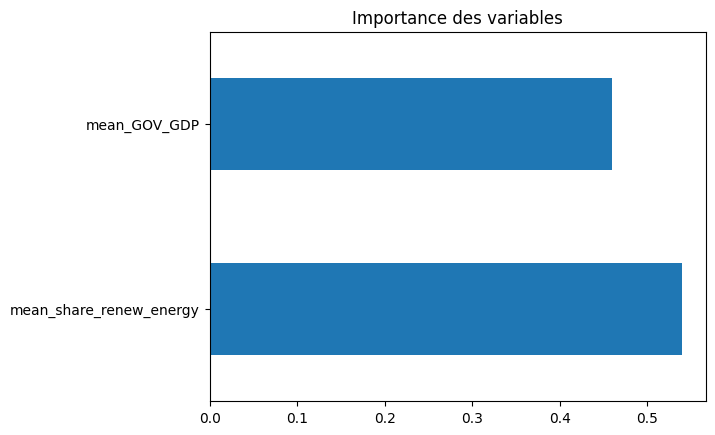

In [ ]:
#Importance des variables

import pandas as pd
import matplotlib.pyplot as plt

# Récupérer l'importance des variables
feature_importances = pd.Series(rf.feature_importances_, index=X.columns)

# Afficher les variables les plus importantes
feature_importances.sort_values(ascending=False).plot(kind='barh', title='Importance des variables')
plt.show()



rq : voir pour ajouter d'autres variables

Data visualization

In [ ]:
data

,name_en,name_fr,country,iso3,mean_energy_price,mean_GDP_per_capita,mean_HICP_inflation,mean_NRJ_dependency,mean_NRJ_productivity,mean_POLL_death,mean_GREEN_Bound,mean_GREEN_COP21,mean_GREEN_Losses,mean_GREEN_employment,mean_GREEN_enviro_protection,mean_GREEN_gross_value,mean_GREEN_investments,mean_GREEN_tax,mean_FDI_impact,mean_GOV_GDP,mean_GOV_bound,mean_GOV_deficit,mean_share_renew_energy,mean_CO2_emissions,besoin_aide,niveau_besoin
0,Croatia,Croatie,HR,HRV,0.175217,2.945833,2.591667,47.643618,7.673333,114.941176,0.0,0.47,22.510682,2319895.0,0.562500,1.644444,375.637368,3.682759,-6.537475,83.376667,3.284167,-2.541667,26.50435,79.372727,0,0
1,Romania,Roumanie,RO,ROU,0.287683,4.429167,3.841667,26.227059,8.495833,126.117647,0.7,52.97,21.244773,19107921.0,0.558824,2.802000,2227.852105,2.294828,12.117424,90.237931,6.394167,-4.091667,22.44690,49.530303,0,2
2,Latvia,Lettonie,LV,LVA,0.289067,4.468000,3.341667,58.673618,6.618750,73.411765,10.5,0.82,13.584318,1640729.0,0.400000,2.837778,458.715789,2.701034,6.196840,88.116667,3.273333,-2.208333,36.54865,43.642424,0,2
3,Austria,Autriche,AT,AUT,0.198467,0.916667,2.883333,66.289353,8.568333,58.470588,8.3,2641.17,40.223636,19383640.0,0.325000,4.484000,3213.635789,2.444828,6.484691,89.144828,2.855000,-2.333333,31.83285,105.006061,0,2
4,Lithuania,Lituanie,LT,LTU,0.247333,4.780000,3.666667,63.143147,6.910417,76.235294,0.0,18.99,16.253864,3705280.0,0.691667,2.415385,666.511053,2.072414,0.894307,89.506667,2.880000,-1.308333,22.81555,39.812121,0,2
5,Spain,Espagne,ES,ESP,0.252800,1.012000,1.850000,73.347853,8.361250,44.058824,7.6,6967.47,52.181136,31114862.0,0.246154,2.469000,4896.697895,1.860690,8.106235,91.203333,3.149167,-5.666667,15.26090,121.993939,0,0
6,Slovenia,Slovénie,SI,SVN,0.165267,2.124000,2.225000,49.982029,6.699583,74.411765,0.0,42.87,191.309091,2391372.0,0.914286,1.606923,355.560000,3.664138,7.977310,87.053333,3.112500,-3.408333,21.74110,98.715152,0,1
7,Belgium,Belgique,BE,BEL,0.257600,1.095833,2.525000,78.216324,5.556667,62.411765,14.8,1614.33,34.092500,5045574.0,0.462500,1.795556,3966.281053,2.485172,11.365664,89.534483,2.949167,-3.466667,7.67355,94.218182,1,0
8,Netherlands,Pays-Bas,NL,NLD,0.250000,1.116000,2.633333,37.543235,6.666667,50.941176,11.1,6742.48,15.590000,19285852.0,0.477778,2.131818,2641.880000,3.531034,5.896115,89.556667,2.640000,-1.008333,6.78340,96.000000,1,0
9,Poland,Pologne,PL,POL,0.167360,3.729167,3.466667,21.813794,6.564583,114.058824,3.8,147.37,12.435682,15233320.0,0.600000,2.348889,2674.091579,2.471724,10.176542,88.282759,5.583333,-3.033333,11.36660,84.763636,1,0


In [ ]:
data.describe()


,mean_energy_price,mean_GDP_per_capita,mean_HICP_inflation,mean_NRJ_dependency,mean_NRJ_productivity,mean_POLL_death,mean_GREEN_Bound,mean_GREEN_COP21,mean_GREEN_Losses,mean_GREEN_employment,mean_GREEN_enviro_protection,mean_GREEN_gross_value,mean_GREEN_investments,mean_GREEN_tax,mean_FDI_impact,mean_GOV_GDP,mean_GOV_bound,mean_GOV_deficit,mean_share_renew_energy,mean_CO2_emissions,besoin_aide,niveau_besoin
count,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,2.500000e+01,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.00000
mean,0.208204,2.311255,2.635667,55.118436,7.248150,71.105882,6.896000,6480.604400,31.761372,1.241164e+07,0.487009,2.460795,2830.281811,2.688841,3.699797,88.567821,3.450467,-2.434000,19.703802,85.064727,0.440000,0.64000
std,0.057889,1.406652,0.910807,24.232743,2.100272,44.375693,5.926809,17728.710888,36.735003,1.557782e+07,0.190819,1.175383,3688.504896,0.567622,10.248148,1.799074,1.135459,1.530887,11.312432,25.500257,0.506623,0.81035
min,0.107600,0.387500,1.241667,4.645794,4.659583,10.352941,0.000000,0.000000,2.552045,2.626600e+05,0.225000,0.631667,26.490000,1.860690,-37.148363,83.376667,2.207500,-5.666667,5.112150,39.812121,0.000000,0.00000
25%,0.164633,1.012500,1.850000,37.543235,5.726667,44.058824,0.000000,18.990000,12.567045,2.226384e+06,0.383333,1.795556,450.814737,2.300690,3.773871,87.341379,2.865000,-3.408333,11.516950,67.272727,0.000000,0.00000
50%,0.198467,2.124000,2.525000,55.578882,6.774167,62.411765,6.300000,147.370000,21.244773,6.043897e+06,0.418182,2.348889,1295.963684,2.485172,6.484691,89.144828,3.113333,-2.333333,15.260900,89.851515,0.000000,0.00000
75%,0.252800,3.483333,3.341667,73.347853,8.361250,91.647059,11.100000,2641.170000,40.223636,1.910792e+07,0.600000,2.802000,3966.281053,2.884828,8.106235,89.556667,3.562500,-1.308333,26.719500,101.387879,1.000000,1.00000
max,0.298900,4.780000,4.625000,100.615912,14.102917,205.941176,16.300000,75708.130000,191.309091,6.567541e+07,0.914286,5.850909,14650.290526,4.133793,12.600088,91.203333,6.571667,1.225000,51.099500,144.924242,1.000000,2.00000


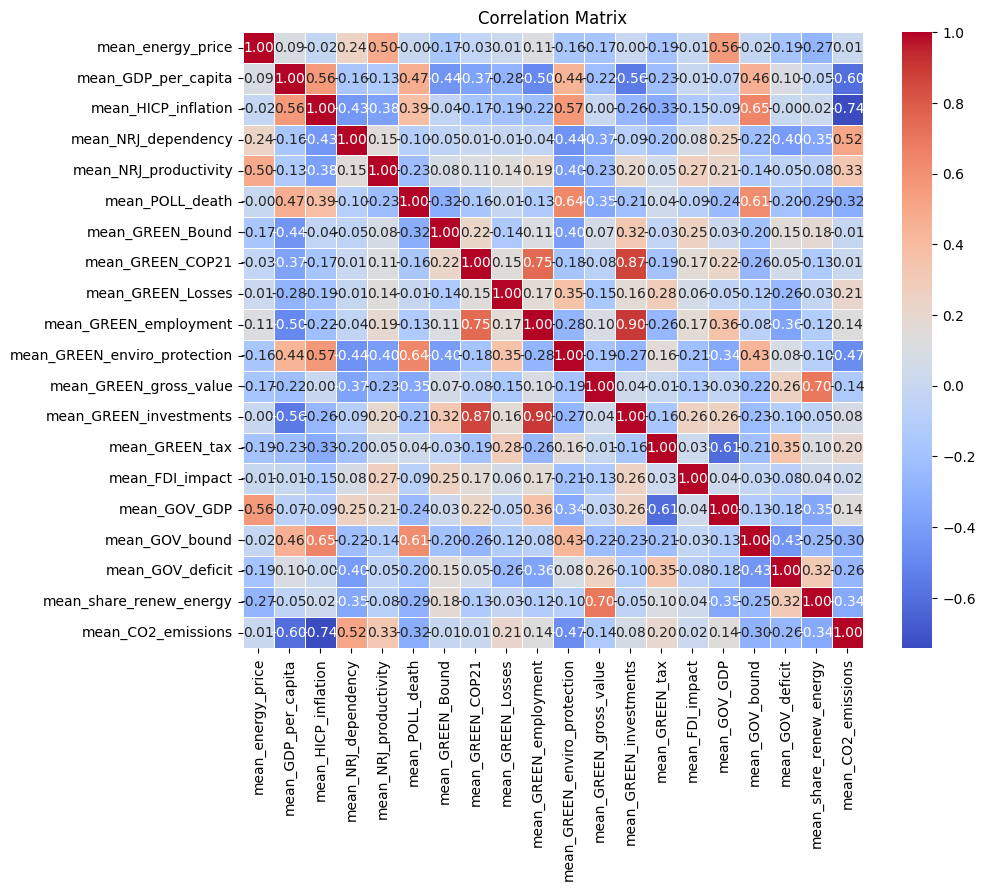

In [ ]:
# prompt: afficher la matrice de corrélations des variables du dataframe data

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'dataframe' is defined as in your provided code
#  dataframe = data.copy()
#  dataframe.drop(columns=['name_en','name_fr','country','iso3'], inplace=True)

# Calculate the correlation matrix
corr_matrix = dataframe.corr()

# Display the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()


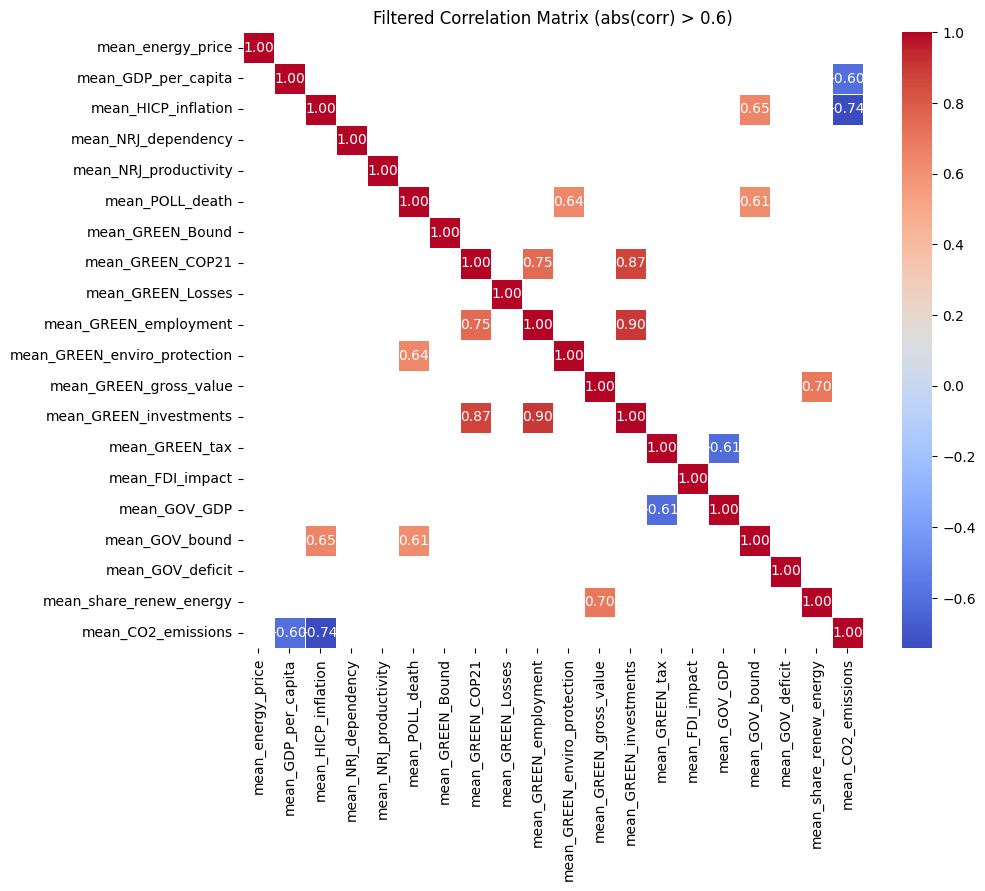

In [ ]:
# prompt: ne garder que les valeurs de la matrice de corrélation supérieur à 0,6 en valeur absolu et supprimer les valeurs qui ne rentre pas dans cette condition, affiche la matrice de corrélation

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'dataframe' is defined as in your provided code
#  dataframe = data.copy()
#  dataframe.drop(columns=['name_en','name_fr','country','iso3'], inplace=True)

# Calculate the correlation matrix
corr_matrix = dataframe.corr()

# Filter the correlation matrix to keep only values above 0.6 in absolute value
corr_matrix_filtered = corr_matrix[abs(corr_matrix) > 0.6]

# Display the filtered correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_filtered, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Filtered Correlation Matrix (abs(corr) > 0.6)")
plt.show()


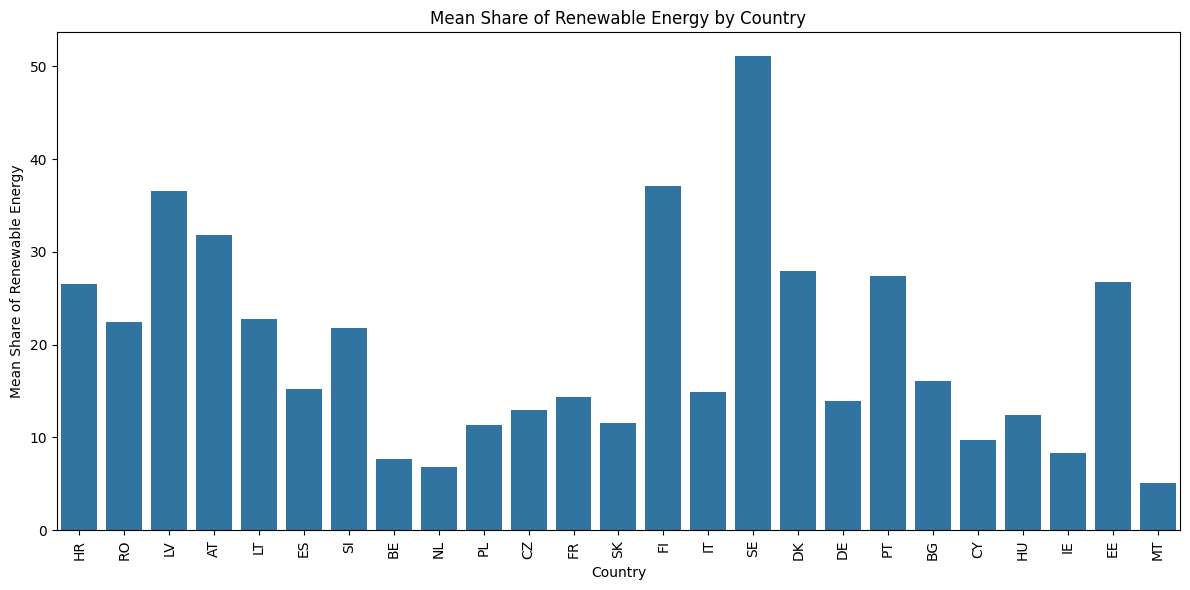

In [ ]:
# prompt: Bar chart avec share_renew_energy par pays

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'data' DataFrame is already loaded as in the provided code

plt.figure(figsize=(12, 6))
sns.barplot(x='country', y='mean_share_renew_energy', data=data)
plt.xlabel('Country')
plt.ylabel('Mean Share of Renewable Energy')
plt.title('Mean Share of Renewable Energy by Country')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


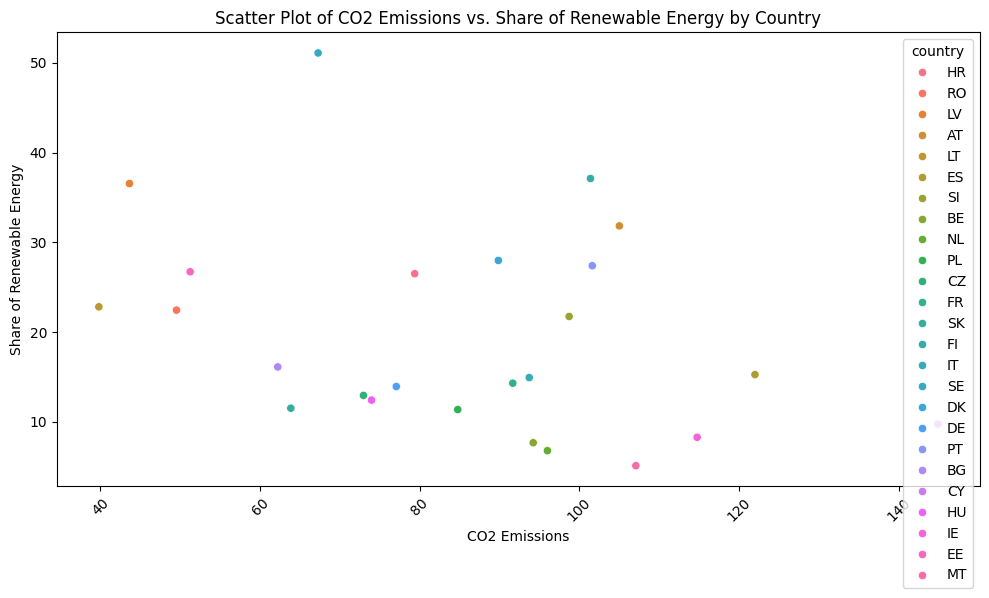

In [ ]:
# prompt:  Scatter plot entre CO2_emissions et share_renew_energy par pays

# Assuming 'data' DataFrame is already loaded as in the provided code
plt.figure(figsize=(10, 6))
sns.scatterplot(x='mean_CO2_emissions', y='mean_share_renew_energy', hue='country', data=data)
plt.xlabel('CO2 Emissions')
plt.ylabel('Share of Renewable Energy')
plt.title('Scatter Plot of CO2 Emissions vs. Share of Renewable Energy by Country')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# prompt: share_renew_energy représentée sur une carte par pays

import plotly.express as px

fig = px.choropleth(data, locations="iso3",
                    color="mean_share_renew_energy",
                    hover_name="name_en",
                    color_continuous_scale=px.colors.sequential.Plasma)
fig.show()


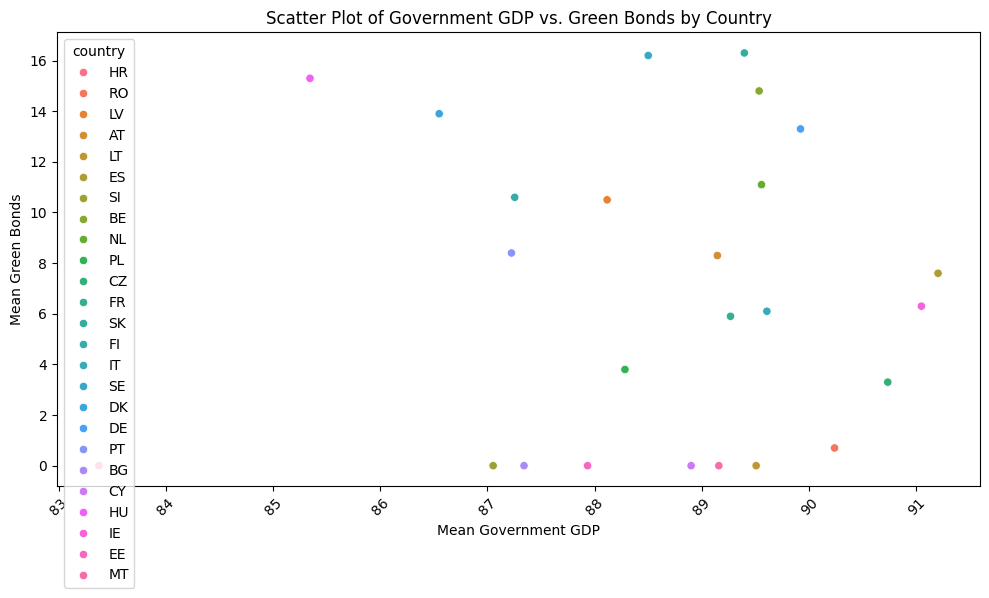

In [ ]:
# prompt: GREEN_Bound et GOV_GDP pour voir si les pays avec un PIB plus élevé investissent davantage via les obligations vertes.

# Assuming 'data' DataFrame is already loaded as in the provided code
# and contains columns 'country' and 'mean_GOV_GDP'

plt.figure(figsize=(10, 6))
sns.scatterplot(x='mean_GOV_GDP', y='mean_GREEN_Bound', hue='country', data=data)
plt.xlabel('Mean Government GDP')
plt.ylabel('Mean Green Bonds')
plt.title('Scatter Plot of Government GDP vs. Green Bonds by Country')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# prompt: fait moi un scanner plot des pays en fonction de mean_share_renew_energy et mean_NRJ_dependency

import plotly.express as px

fig = px.scatter(data, x="mean_share_renew_energy", y="mean_NRJ_dependency", color="country",
                 hover_data=['name_en'], title="Pays en fonction de mean_share_renew_energy et mean_NRJ_dependency")
fig.show()


les pays ayant besoin d'aide : ceux dépendants avec une faible part d'énergie renouvelables

In [ ]:

import plotly.express as px

fig = px.scatter(data, x="mean_share_renew_energy", y="mean_GDP_per_capita", color="country",
                 hover_data=['name_en'], title="Pays en fonction de mean_share_renew_energy et mean_GDP_per_capita")
fig.show()

Données économiques :
- CO2 : les+ : espagne, irlande, finlande

pays  les plus dépendants à l'import et ceux avec un prix élevé d'energie (iralnde, espagne, italie)

paysqui investissemnt le plus dans le green n sont pas ceux qui ont la plus haute part de renew energy (ex : france et allemagne)

plus le pays est dépendant aux importation plus il émet de CO2 et moins il a une share de renew importante

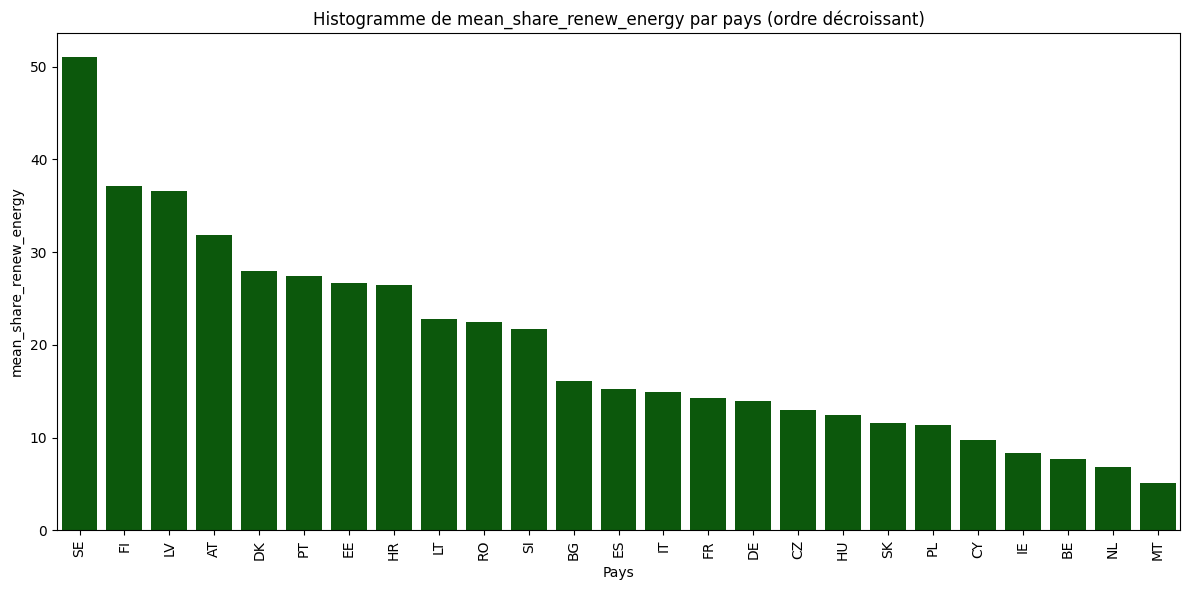

In [ ]:
# prompt: trace un histogramme de mean_share_renew_energy par pays dans l'ordre décroissant en vert foncé

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(x='country', y='mean_share_renew_energy', data=data, order=data.sort_values('mean_share_renew_energy', ascending=False)['country'], color="darkgreen")
plt.xlabel('Pays')
plt.ylabel('mean_share_renew_energy')
plt.title('Histogramme de mean_share_renew_energy par pays (ordre décroissant)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


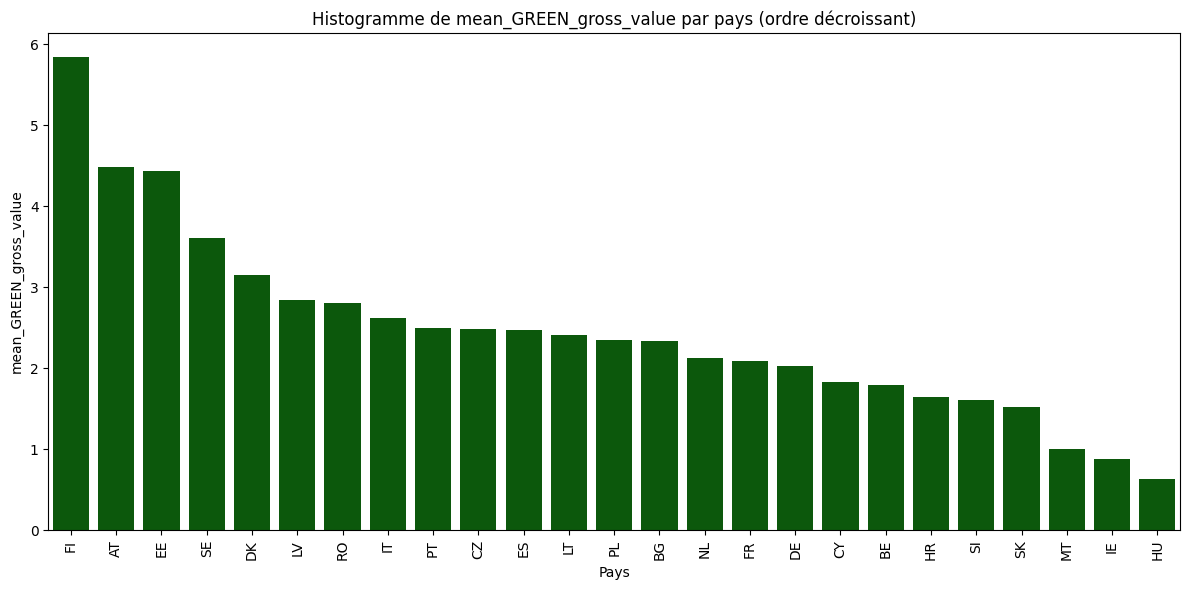

In [ ]:
# prompt: trace un histogramme de mean_GREEN_gross_value par pays dans l'ordre décroissant en vert foncé

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(x='country', y='mean_GREEN_gross_value', data=data, order=data.sort_values('mean_GREEN_gross_value', ascending=False)['country'], color="darkgreen")
plt.xlabel('Pays')
plt.ylabel('mean_GREEN_gross_value')
plt.title('Histogramme de mean_GREEN_gross_value par pays (ordre décroissant)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [ ]:
data.describe()


,mean_energy_price,mean_GDP_per_capita,mean_HICP_inflation,mean_NRJ_dependency,mean_NRJ_productivity,mean_POLL_death,mean_GREEN_Bound,mean_GREEN_COP21,mean_GREEN_Losses,mean_GREEN_employment,mean_GREEN_enviro_protection,mean_GREEN_gross_value,mean_GREEN_investments,mean_GREEN_tax,mean_FDI_impact,mean_GOV_GDP,mean_GOV_bound,mean_GOV_deficit,mean_share_renew_energy,mean_CO2_emissions,besoin_aide,niveau_besoin
count,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,2.500000e+01,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.00000
mean,0.208204,2.311255,2.635667,55.118436,7.248150,71.105882,6.896000,6480.604400,31.761372,1.241164e+07,0.487009,2.460795,2830.281811,2.688841,3.699797,88.567821,3.450467,-2.434000,19.703802,85.064727,0.440000,0.64000
std,0.057889,1.406652,0.910807,24.232743,2.100272,44.375693,5.926809,17728.710888,36.735003,1.557782e+07,0.190819,1.175383,3688.504896,0.567622,10.248148,1.799074,1.135459,1.530887,11.312432,25.500257,0.506623,0.81035
min,0.107600,0.387500,1.241667,4.645794,4.659583,10.352941,0.000000,0.000000,2.552045,2.626600e+05,0.225000,0.631667,26.490000,1.860690,-37.148363,83.376667,2.207500,-5.666667,5.112150,39.812121,0.000000,0.00000
25%,0.164633,1.012500,1.850000,37.543235,5.726667,44.058824,0.000000,18.990000,12.567045,2.226384e+06,0.383333,1.795556,450.814737,2.300690,3.773871,87.341379,2.865000,-3.408333,11.516950,67.272727,0.000000,0.00000
50%,0.198467,2.124000,2.525000,55.578882,6.774167,62.411765,6.300000,147.370000,21.244773,6.043897e+06,0.418182,2.348889,1295.963684,2.485172,6.484691,89.144828,3.113333,-2.333333,15.260900,89.851515,0.000000,0.00000
75%,0.252800,3.483333,3.341667,73.347853,8.361250,91.647059,11.100000,2641.170000,40.223636,1.910792e+07,0.600000,2.802000,3966.281053,2.884828,8.106235,89.556667,3.562500,-1.308333,26.719500,101.387879,1.000000,1.00000
max,0.298900,4.780000,4.625000,100.615912,14.102917,205.941176,16.300000,75708.130000,191.309091,6.567541e+07,0.914286,5.850909,14650.290526,4.133793,12.600088,91.203333,6.571667,1.225000,51.099500,144.924242,1.000000,2.00000


## Industrialisation